# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [4]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [5]:
# frequency table for prestige and whether or not someone was admitted
prestige_admit = pd.crosstab(index=df["admit"], 
                           columns=df["prestige"])

prestige_admit.index= ["admitted","not admitted"]

prestige_admit

prestige,1.0,2.0,3.0,4.0
admitted,28,95,93,55
not admitted,33,53,28,12


In [6]:
g = df.groupby('admit')
g.count()

,gre,gpa,prestige
admit,,,
0,271,271,271
1,126,126,126


In [7]:
g['prestige'].count()

admit
0    271
1    126
Name: prestige, dtype: int64

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [8]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
df_new = pd.concat([df, dummy_ranks], axis=1)

In [9]:
df_new.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0.0,0.0,1.0,0.0
1,1,660.0,3.67,3.0,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,1.0,0.0,0.0,0.0
3,1,640.0,3.19,4.0,0.0,0.0,0.0,1.0
4,0,520.0,2.93,4.0,0.0,0.0,0.0,1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: K-1. So three out of the four classes.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [10]:
cols_to_keep = ['admit', 'gre', 'gpa']
print cols_to_keep

['admit', 'gre', 'gpa']


In [11]:
handCalc = df[cols_to_keep].join(dummy_ranks.ix[: 'prestige_1':])

In [12]:
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           0.0           1.0           0.0
1      1  660.0  3.67           0.0           0.0           1.0           0.0
2      1  800.0  4.00           1.0           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           0.0           1.0


In [13]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
crosstab_prestige1 = pd.crosstab(index=handCalc["admit"], columns=handCalc["prestige_1.0"])

crosstab_prestige1.index= ["not admitted","admitted"]

crosstab_prestige1

prestige_1.0,0.0,1.0
not admitted,243,28
admitted,93,33


In [14]:
type(crosstab_prestige1)

pandas.core.frame.DataFrame

In [15]:
crosstab_prestige1[1.0]

not admitted    28
admitted        33
Name: 1.0, dtype: int64

In [16]:
crosstab_prestige1[: "not admitted"]

prestige_1.0,0.0,1.0
not admitted,243,28


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [17]:
odds_1 = (33 / float(61))
odds_1
#number of people admitted if prestige 1 / # number of people who attended #1 ranked college

0.5409836065573771

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [18]:
odds_2 = (93 / float(336))
odds_2
# of people admitted who did not attend #1 ranked college / # of people who did not attend a #1 ranked college

0.2767857142857143

#### 3.3 Calculate the odds ratio

In [19]:
odds_ratio1 = odds_1 / odds_2
print odds_ratio1
# odds of admission if you did attend prestige 1 school / odds of admission if you did not attnend a prestige 1 school

1.95452141724


#### 3.4 Write this finding in a sentenance: 

Odds for admission increase by 95% if you attended a #1 ranked college.

#### 3.5 Print the cross tab for prestige_4

In [20]:
crosstab_prestige4 = pd.crosstab(index=handCalc["admit"], 
                           columns=handCalc["prestige_4.0"])

crosstab_prestige4.index= ["not admitted","admitted"]

crosstab_prestige4

prestige_4.0,0.0,1.0
not admitted,216,55
admitted,114,12


#### 3.6 Calculate the OR 

In [21]:
odds_ratio4 = (12 / float(67)) / (114/ float(330))
odds_ratio4

0.5184603299293008

#### 3.7 Write this finding in a sentence

Odds of admission decrease by around 51% if you attended a #4 ranked college.

## Part 4. Analysis

In [22]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           1.0           0.0
1      1  660.0  3.67           0.0           1.0           0.0
2      1  800.0  4.00           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [23]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [24]:
train_cols = data.columns[1:]

print train_cols

Index([u'gre', u'gpa', u'prestige_2.0', u'prestige_3.0', u'prestige_4.0',
       u'intercept'],
      dtype='object')


#### 4.2 Fit the model

In [25]:
logit = sm.Logit(data['admit'], data[train_cols])

#### 4.3 Print the summary results

In [26]:
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Aug 2016   Pseudo R-squ.:                 0.08166
Time:                        18:36:37   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [27]:
print np.exp(result.params)

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64


In [28]:
conf = result.conf_int()
conf['OR'] = result.params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


#### 4.5 Interpret the OR of Prestige_2

Odds of admission decrease by 50% if you attended a #2 college, with the true population effect between 63% and 6%.

#### 4.6 Interpret the OR of GPA

Answer: Odds of admission increase by 118% for every 1.0 increase in GPA.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [29]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [30]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [31]:
# create dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks2 = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks2.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']

In [32]:
# keep only what we need for making predictions
cols_to_keep2 = ['gre', 'gpa', 'prestige', 'intercept']
combos2 = combos[cols_to_keep2].join(dummy_ranks.ix[:, 'prestige_2.0':])

#### 5.2 Make predictions on the enumerated dataset

In [33]:
combos2['admit_pred'] = result.predict(combos2[train_cols])
print combos2.tail()

       gre       gpa  prestige  intercept  prestige_2.0  prestige_3.0  \
395  800.0  3.806667       4.0        1.0           1.0           0.0   
396  800.0  4.000000       1.0        1.0           0.0           1.0   
397  800.0  4.000000       2.0        1.0           1.0           0.0   
398  800.0  4.000000       3.0        1.0           1.0           0.0   
399  800.0  4.000000       4.0        1.0           0.0           1.0   

     prestige_4.0  admit_pred  
395           0.0    0.545972  
396           0.0    0.419833  
397           0.0    0.582995  
398           0.0    0.582995  
399           0.0    0.419833  


#### 5.3 Interpret findings for the last 4 observations

Answer:
The probability of admission is 0.42 if you have a GRE score of 800, GPA of 4.0, and attended a #3 ranked college.
The probability of admission is 0.58 if you have a GRE score of 800, GPA of 4.0, and attended a #2 ranked college.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

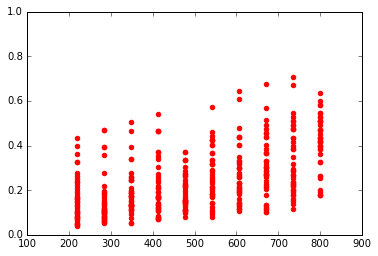

In [56]:
X1 = combos2['gre']
X2 = combos2['gpa']
Y = combos2['admit_pred']
plt.scatter(X1,Y,color='red')
plt.ylim((0,1))
plt.show()

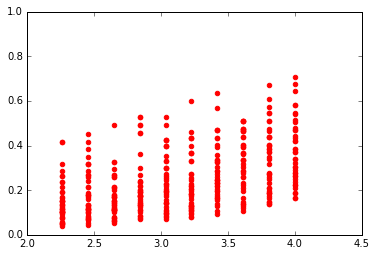

In [52]:
plt.scatter(X2,Y,color='red')
plt.ylim((0,1))
plt.show()